In this last post of the Bayesian Modeling for Oceanographers series, I will demonstrate the development of hierarchical models, illustrated through modeling chlorophyll as a function of remote sensing reflectance. Hierarchical models are particularly useful, and are in fact the recommended default, whenever there is a possibility of grouping the data in a meaningful way. This opportunity for clustering is readily available in the NOMAD dataset; a dataset that is commonly used for the development of algorithms aimed at biological satellite oceanography.<br><br>
#### <u>Pooled, Unpooled,  Partially Pooled</u>
Most models, including those encoutered in the oceanographic literature, pool data in order to capture global trends; they are commonly referred to as '<u>**pooled models**</u>'; the [previous post](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/Bayesian%20Modeling%20for%20Oceanographers%20-%202%20-%20Inference%20using%20OC4.ipynb) illustrated the implementation of a bayesian pooled model. The problem is that pooled models often run into trouble when the data they are fed depart from trends and conditions that dominate the training dataset. This is the case, for example, when a model trained on a set of predominantly blue water observations is given data collected from optically complex coastal sites. Even if similar data are present in the training data, pooled models are not structured to capture local conditions. The result is a loss of potentially valuable information. Moreover, when pooled models are developed using a varied dataset that includes many different environments, the temptation is great for the practitioner to resort to complicated mathematical expressions. While such models are capable of noteworthy performance they are typically difficult to interpret. This has caused the remote sensing community, among others, to create a false dichotomy separating kludgy uninterpretable but practical "empirical models"  from "analytical" or "semi-analytical" models, perceived as principled alternatives that are challenging to work with.<br><br>
To address the issue of applicability to local conditions, the usual recourse is to develop and train models tuned to specific environments. These <u>**unpooled models**</u> have been demonstrably successful, are often simpler in construction and are therefore more readily interpretable and are often reuseable in locations or periods beyond their original application. Reusability, however, requires retraining the model by replacing the training data describing one specific environment with a dataset representing another set of conditions. Such a reset in model training results in the loss of information contained in the discarded observations. This induced 'model amnesia' wastes already sparse *in-situ* data, and fails to maximize the information content of datasets like NOMAD.<br>

#### Partially pooled models
A solution to maximize the information content of a dataset is the '<u>***partially pooled***</u>' model also known as a <u>***hierarchical***</u> model. Quoting from Betancourt & Girolami (2013), "Hierarchical models are defined by the organization of a model's parameters into exchangeable groups, and the resulting conditional independencies between those groups." Put differently, a partially pooled model is a framework of group-specific models of similar construction that are connected to each other via the distributions that generate their parameters. These parameters, in the present post, are those of a simple linear regression; namely an intercept and a slope, designated $\alpha$ and $\beta$, respectively in the model formulations.<br><br>


**Fig. 1** illustrates the structure of a bayesian hierarchical model with data clustered into N groups. The hyperpriors enable the flow of information between submodels resulting in localized fits constrained by global trends. Importantly, this addresses, among other problems, in a principled way, the oft-encountered issue of imbalanced datasets, where a handful of locations is more sampled than others.
<br><br>
<figure>
<img src='figJar/Hierarchical_models/hierarchical_mlr.png' width=800px>
<figcaption><i><strong>Fig. 1.</strong> Schema of a hierarchical bayesian multi-linear regression model with data grouped into N categories.</i></figcaption>
</figure>
<br>

#### Clustering the NOMAD dataset

For illustration I use the NOMAD dataset to estimate in situ chlorophyll from remote sensing reflectance. The model I use is a simple linear regression, where the predictor is the ratio $\frac{max(Rrs_{412}, Rrs_{489}, Rrs_{510})}{Rrs_{555}}$; the same as the operational $OC_4$ algorithm. Here however, there is no projection of the input into high dimensional space. Both predictor (band ratio) and predicted (chl) are $log_{10}$-transformed, as in the [previous post]((https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/Bayesian%20Modeling%20for%20Oceanographers%20-%202%20-%20Inference%20using%20OC4.ipynb)), the regression model is: <br><br>
$$ log_{10}(chl) = \alpha + \beta * log_{10}(\frac{max(Rrs_{412}, Rrs_{489}, Rrs_{510})}{Rrs_{555}})$$
<br>
Missing data was imputed where possible using adjacent bands. The mechanics of imputation are documented in the notebook available [here](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/DataPrep-2-Developing_imputation_models_for_missing_data.ipynb). The finalized data used in the models presented here are displayed below (**Fig. 2**).
<br><br>
<figure>
<img src='figJar/datapairgrid.png' width=600px>
<figcaption><i><strong>Fig. 2.</strong> Pairwise comparison of $log_{10}$-transfomed reflectance band ratio (MxBl-Gr) and $log_{10}$ chlorophyl (chl_l)</i></figcaption>
</figure>
<br>

For the purpose of this tutorial I will use two grouping schemes. These include (1) blue band clustering, and (2) spatial clustering.
<br>
(1) The blue band clustering assumes that the band used in the ratio distinguishes specific conditions that led to the collected observations (see e.g. Szeto et al., 2011). The distribution of the data according to this scheme is shown below (**Fig.3**):

<figure>
<img src='figJar/datapairgrid_blue.png' width=600px>
<figcaption><i><strong>Fig. 3.</strong> Pairwise comparison as in Fig.2, with hue indicating blue band used in the band ratio</i></figcaption>
</figure>
<br>

(2) The spatial clustering is done by identifying the Longhurst biogeochemical province each observation belongs to. **Fig. 4** shows the global distribution of these provinces. 
<br>
<figure>
<img src='figJar/Hierarchical_models/lhurstbiogeog.jpg'>
<figcaption><i><strong>Fig. 4.</strong> Longhurst provinces used to classify observations as being subject to a particular biogeochemical forcing.</i></figcaption>
</figure>
<br>
There are a total of 54 provinces, not all of which are used here due to a lack of observations. Moreover, 
the number of observations belonging to each province is quite variable, ranging from more than 1000 in the *Austral Polar Province*, to several dozens in the *Benguela Upwelling Province*, to just 1 in the *East India Coastal Province*. While problematic for many machine learning approaches, I will show that because of the information flow between groups during fitting, this kind of imbalance in a dataset is not a problem for Hierchical Bayes. Meaningful inference can still be achieved for groups containing precious few observations. **Fig. 5** features data distributions for some of the provinces, and serves to illustrate that the relationship between predicted and predictor can vary greatly between provinces. Some provinces, like the NorthWest Arabian Upwelling province shown in Fig. 5, suggests that the blue-green ratio is insufficent as a predictor. There are a number of ways to move forward with this information. One approach, is to bring in additional predictors to tease out the processes generating the observed chlorophyll values; e.g. sea surface temperature, seasonality, etc. Another approach, which can be used in conjunction with the previous is to use a two-pronged clustering scheme, by combining groups in parallel; this is the purview of cross-classified models. One such model comes to mind in the present case, namely one using a combined blue-band/province clustering scheme.

<br>
<figure>
<img src='figJar/datapairgrid_province.png'>
<figcaption><i><strong>Fig. 5.</strong> Pairwise plot of observations for 4 Longhurst provinces, showing differences and similarities in distribution between sampling locations</i></figcaption>
</figure>
<br>
<br>
In summary I will fit three hierarchical partially pooled bayesian regression models. Going forward, and for baseline, I will fit a pooled bayesian model using the original $OC_4$ formulation. Finally, I illustrate evaluation, model comparison, and model selection using information theory-based assessment and cross-validation, and discuss the findings.

In [29]:
import pickle
import re
import warnings
warnings.filterwarnings('ignore')
# Importing libraries
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, kdeplot, jointplot, FacetGrid, distplot, dark_palette
from scipy.stats import skew
import theano.tensor as tt
from matplotlib import cm
from cmocean import cm as cmo
from matplotlib.colors import rgb2hex
import pprint

In [2]:
# Setting graphics...
% matplotlib inline
pl.style.use('bmh')
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['figure.titlesize'] = 20
rcParams['axes.titlesize'] = 18
oranges = dark_palette("orange", as_cmap=True)

In [3]:
df = pd.read_pickle('./pickleJar/df_log.pkl')

In [4]:
df.head().T

0  \
id                                           4045   
datetime                      1998-08-29 17:55:00   
lat                                        60.587   
lon                                      -146.409   
etopo2_l                                  1.91381   
oisst                                       13.04   
sal_l                                         NaN   
rrs411_l                                 -2.48181   
rrs443_l                                 -2.39369   
rrs489_l                                 -2.32961   
rrs510_l                                 -2.29265   
rrs555_l                                 -2.26695   
rrs670_l                                 -3.07818   
mxBl_l                                   -2.29265   
mxBlId                                     rrs510   
mxBlCat                                         2   
mxBlColor                                 #4eb3d3   
mxBl2_l                                  -2.29265   
mxBl2Id                                    rrs510   
mxBl2Cat                                        3   
mxBl2Color                                #7bccc4   
Province      Alaska Downwelling Coastal Province   
provCode                                     ALSK   
provNum                                         1   
provCat                                         0   
provColor                                 #440154   
biome                                     Coastal   
biomCat                                         0   
biomColor                                 #fbb4ae   
blueProvince                          ALSK-rrs510   
blProvCat                                       2   
blProvColor                               #45085B   
blueBiome                          Coastal-rrs510   
blBiomCat                                       2   
MxBl-Gr                                -0.0257098   
blBiomColor                               #423D84   
is_hplc                                         0   
chl_l                                    0.317436   
chl                                         2.077   

                                                1  \
id                                           4056   
datetime                      1998-09-02 15:52:00   
lat                                        60.674   
lon                                      -147.682   
etopo2_l                                  1.14613   
oisst                                       11.74   
sal_l                                         NaN   
rrs411_l                                 -2.69759   
rrs443_l                                 -2.57914   
rrs489_l                                 -2.44558   
rrs510_l                                 -2.38804   
rrs555_l                                 -2.36376   
rrs670_l                                 -3.13471   
mxBl_l                                   -2.38804   
mxBlId                                     rrs510   
mxBlCat                                         2   
mxBlColor                                 #4eb3d3   
mxBl2_l                                  -2.38804   
mxBl2Id                                    rrs510   
mxBl2Cat                                        3   
mxBl2Color                                #7bccc4   
Province      Alaska Downwelling Coastal Province   
provCode                                     ALSK   
provNum                                         1   
provCat                                         0   
provColor                                 #440154   
biome                                     Coastal   
biomCat                                         0   
biomColor                                 #fbb4ae   
blueProvince                          ALSK-rrs510   
blProvCat                                       2   
blProvColor                               #45085B   
blueBiome                          Coastal-rrs510   
blBiomCat                                       2   
MxBl-Gr                                -0.0242776   
blBiomColor        

In [74]:
d_ = df[['mxBlId','Province', 'blueBiome', 'blueProvince', 'provCat','mxBlCat', 'MxBl-Gr',
         'oisst', 'etopo2_l', 'chl', 'chl_l']].dropna()
d_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4126 entries, 0 to 4458
Data columns (total 11 columns):
mxBlId          4126 non-null object
Province        4126 non-null object
blueBiome       4126 non-null category
blueProvince    4126 non-null category
provCat         4126 non-null int8
mxBlCat         4126 non-null int8
MxBl-Gr         4126 non-null float64
oisst           4126 non-null float64
etopo2_l        4126 non-null float64
chl             4126 non-null float64
chl_l           4126 non-null float64
dtypes: category(2), float64(5), int8(2), object(2)
memory usage: 280.2+ KB


In [6]:
# create dictionary of category mapping for various clustering schemes
blue_mapping = dict(enumerate(df['mxBlId'].astype('category').cat.categories))
biome_mapping = dict(enumerate(df['biome'].astype('category').cat.categories))
prov_mapping = dict(enumerate(df['provCode'].astype('category').cat.categories))

In [22]:
df.blueBiome.value_counts()

Coastal-rrs510       669
Coastal-rrs489       586
Polar-rrs443         572
Polar-rrs489         504
Trades-rrs443        483
Westerlies-rrs443    464
Coastal-rrs443       318
Polar-rrs510         276
Westerlies-rrs510    185
Westerlies-rrs489    176
Trades-rrs510        161
Trades-rrs489         65
Name: blueBiome, dtype: int64

In [21]:
df.provCode.value_counts()

APLR    1175
NWCS     703
CCAL     556
NPSW     377
CARB     209
NASW     172
NATR     125
SATL     118
NPPF     114
GUIA      84
WTRA      79
NASE      68
BENG      67
ARAB      65
ARCT      58
BERS      42
MONS      38
WARM      37
KURO      37
PEQD      32
SARC      31
NPTG      27
ETRA      27
ANTA      24
BPLR      22
MEDI      16
SPSG      13
FKLD      13
BRAZ      12
ISSG      12
NEWZ      12
SANT      11
CHIL      11
CNRY      10
NECS      10
EAFR       9
ALSK       8
SUND       7
NADR       6
PNEC       5
CHIN       5
GFST       5
SSTC       4
PSAE       2
INDE       1
Name: provCode, dtype: int64

In [31]:
d_.head()

mxBlId                             Province       blueBiome blueProvince  \
0  rrs510  Alaska Downwelling Coastal Province  Coastal-rrs510  ALSK-rrs510   
1  rrs510  Alaska Downwelling Coastal Province  Coastal-rrs510  ALSK-rrs510   
2  rrs510  Alaska Downwelling Coastal Province  Coastal-rrs510  ALSK-rrs510   
3  rrs510  Alaska Downwelling Coastal Province  Coastal-rrs510  ALSK-rrs510   
4  rrs489  Alaska Downwelling Coastal Province  Coastal-rrs489  ALSK-rrs489   

   provCat  mxBlCat   MxBl-Gr  oisst  etopo2_l    chl     chl_l  
0        0        2 -0.025710  13.04  1.913814  2.077  0.317436  
1        0        2 -0.024278  11.74  1.146128  1.799  0.255031  
2        0        2 -0.020502  11.74  2.029384  1.608  0.206286  
3        0        2  0.039941   9.71  2.155336  1.579  0.198382  
4        0        1  0.128449   9.84  2.456366  1.074  0.031004

In [71]:
d2 = d_.loc[(d_.Province=='Atlantic Arctic Province') | (d_.Province=='NW Arabian Upwelling Province')|
            (d_.Province=='Benguela Current Coastal Province')|
            (d_.Province=='Kuroshio Current Province')]

In [92]:
PairGrid()

BENG-rrs510    49
ARAB-rrs443    31
ARAB-rrs489    30
KURO-rrs443    25
ARCT-rrs443    17
ARCT-rrs510    17
ARCT-rrs489    16
BENG-rrs489    13
KURO-rrs489     7
BENG-rrs443     5
KURO-rrs510     3
ARAB-rrs510     2
CHIN-rrs443     0
CHIN-rrs489     0
CNRY-rrs510     0
CHIL-rrs510     0
CHIL-rrs489     0
CNRY-rrs443     0
CHIL-rrs443     0
CNRY-rrs489     0
WTRA-rrs510     0
EAFR-rrs443     0
EAFR-rrs489     0
CCAL-rrs489     0
EAFR-rrs510     0
ETRA-rrs443     0
ETRA-rrs489     0
FKLD-rrs443     0
FKLD-rrs489     0
CCAL-rrs510     0
               ..
SSTC-rrs443     0
SSTC-rrs489     0
SUND-rrs443     0
WARM-rrs443     0
WTRA-rrs443     0
NPSW-rrs510     0
NPSW-rrs489     0
NPSW-rrs443     0
NASW-rrs443     0
GUIA-rrs510     0
INDE-rrs443     0
ISSG-rrs443     0
MEDI-rrs443     0
MONS-rrs443     0
NADR-rrs443     0
NADR-rrs489     0
NASE-rrs443     0
NASE-rrs489     0
NATR-rrs443     0
NPPF-rrs510     0
NATR-rrs489     0
NATR-rrs510     0
NECS-rrs443     0
NECS-rrs489     0
NECS-rrs51

In [86]:
d1 = d_.loc[d_.Province=='NW Arabian Upwelling Province'].dropna()

In [93]:
d1

mxBlId                       Province       blueBiome blueProvince  \
785  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
786  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
787  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
788  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
789  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
790  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
791  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
792  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
793  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
794  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
795  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
796  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
797  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
798  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
799  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
800  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
801  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
802  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
805  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
806  rrs510  NW Arabian Upwelling Province  Coastal-rrs510  ARAB-rrs510   
807  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
808  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
809  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
810  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
811  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
812  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
813  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
814  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
815  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
816  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
..      ...                            ...             ...          ...   
820  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
821  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
822  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
823  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
824  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
825  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
826  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
827  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
828  rrs510  NW Arabian Upwelling Province  Coastal-rrs510  ARAB-rrs510   
829  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
830  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
831  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
832  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
833  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
834  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
835  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
836  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
837  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
838  rrs489  NW Arabian Upwelling Province  Coastal-rrs489  ARAB-rrs489   
839  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
840  rrs443  NW Arabian Upwelling Province  Coastal-rrs443  ARAB-rrs443   
841  rrs443  NW Arabian Upwell

In [91]:
d1b.blueProvince.value_counts()

ARAB-rrs443    31
ARAB-rrs510     2
WTRA-rrs510     0
CNRY-rrs489     0
CARB-rrs510     0
CCAL-rrs443     0
CCAL-rrs489     0
CCAL-rrs510     0
CHIL-rrs443     0
CHIL-rrs489     0
CHIL-rrs510     0
CHIN-rrs443     0
CHIN-rrs489     0
CNRY-rrs443     0
CNRY-rrs510     0
CARB-rrs443     0
EAFR-rrs443     0
EAFR-rrs489     0
EAFR-rrs510     0
ETRA-rrs443     0
ETRA-rrs489     0
FKLD-rrs443     0
FKLD-rrs489     0
GFST-rrs443     0
GFST-rrs489     0
CARB-rrs489     0
BRAZ-rrs443     0
WTRA-rrs489     0
ARCT-rrs443     0
ALSK-rrs489     0
               ..
SSTC-rrs489     0
SUND-rrs443     0
WARM-rrs443     0
WTRA-rrs443     0
NPSW-rrs510     0
NPSW-rrs443     0
INDE-rrs443     0
NPPF-rrs510     0
ISSG-rrs443     0
KURO-rrs443     0
KURO-rrs489     0
KURO-rrs510     0
MEDI-rrs443     0
MONS-rrs443     0
NADR-rrs443     0
NADR-rrs489     0
NASE-rrs443     0
NASE-rrs489     0
NASW-rrs443     0
NATR-rrs443     0
NATR-rrs489     0
NATR-rrs510     0
NECS-rrs443     0
NECS-rrs489     0
NECS-rrs51

In [54]:
d1.blueProvince.unique()

[ARAB-rrs443, ARAB-rrs489, ARAB-rrs510]
Categories (3, object): [ARAB-rrs443, ARAB-rrs489, ARAB-rrs510]

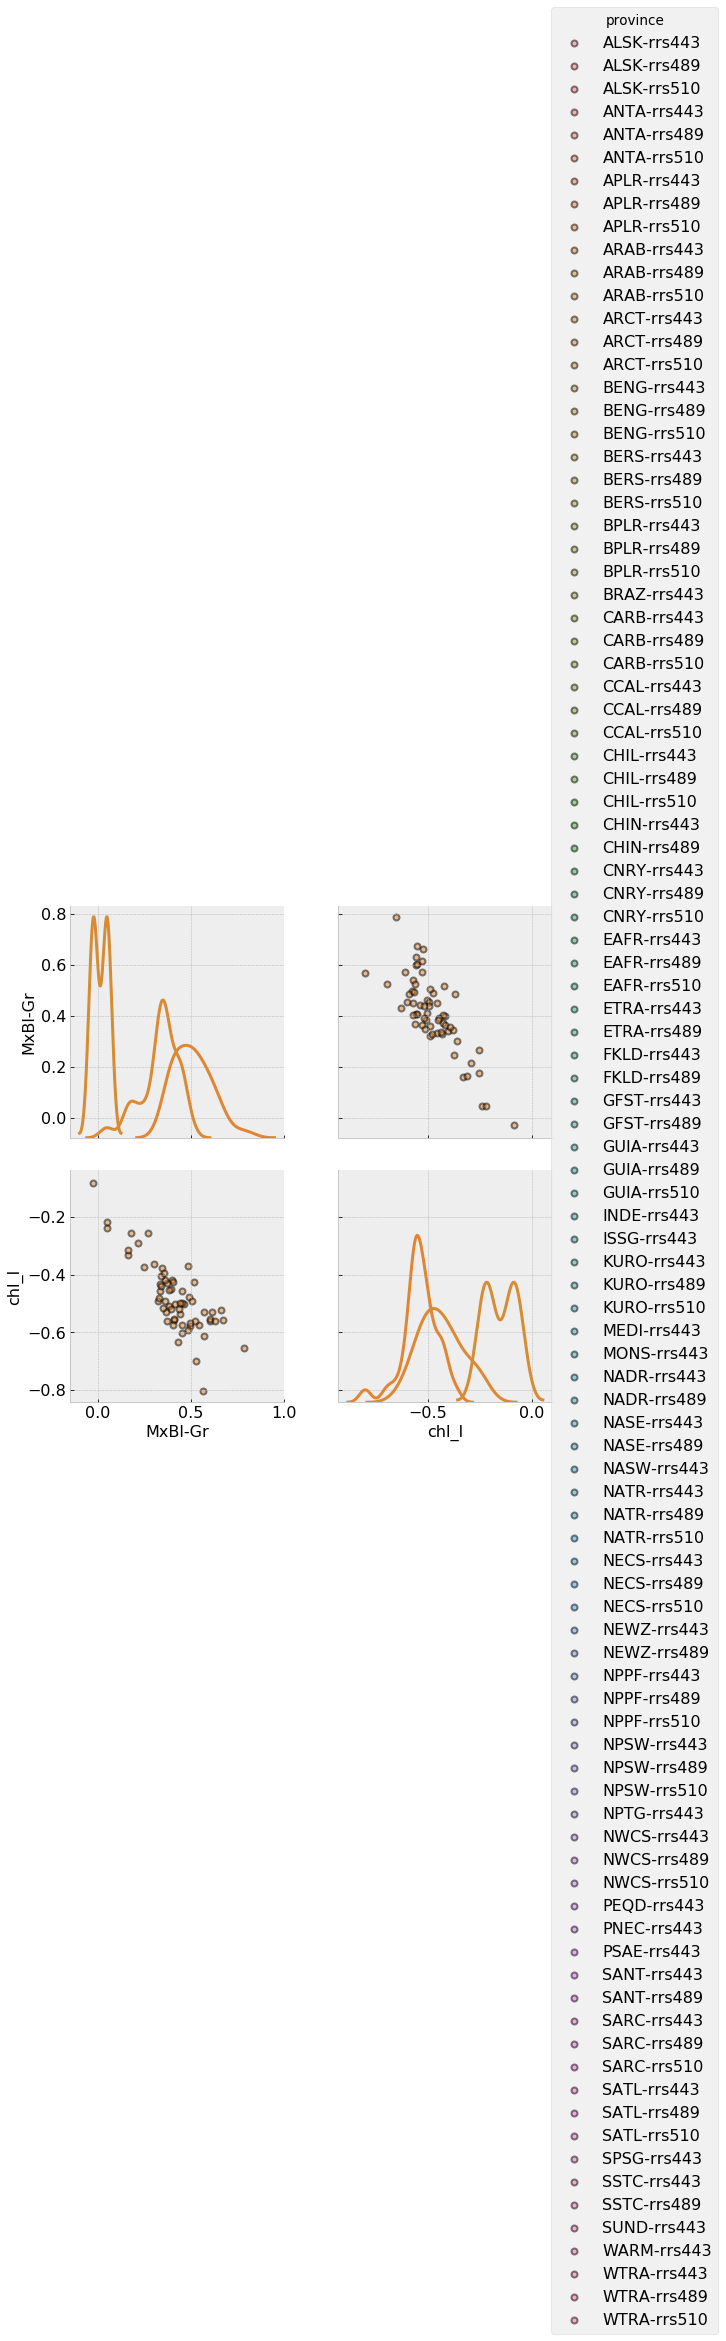

In [41]:
# Pairwise plot with biome band-clustering
vars_ = ['MxBl-Gr', 'chl_l']
g = PairGrid(d2, vars=vars_, size=4, hue='blueProvince',
              dropna=True)
gmu = g.map_offdiag(pl.scatter, edgecolor='k', alpha=0.5, linewidth=2)
#gml = g.map_lower(kdeplot,)
gmd = g.map_diag(kdeplot, lw=3, legend=False);
#g.add_legend(title='province')
#g.savefig('./figJar/datapairgrid_province.png', dpi=300)

In [9]:
d2.Province.value_counts()

Benguela Current Coastal Province    67
NW Arabian Upwelling Province        63
Atlantic Arctic Province             50
Kuroshio Current Province            35
Name: Province, dtype: int64

In [10]:
pprint.pprint(d_.Province.value_counts())

Austral Polar Province                                  1152
NW Atlantic Shelves Province                             630
California Upwelling Coastal Province                    482
N. Pacific Subtropical Gyre Province (West)              374
Caribbean Province                                       208
N. Atlantic Tropical Gyral Province (Trpg)               121
N. Atlantic Subtropical Gyral Province (West) (Stgw)     113
South Atlantic Gyral Province (Satg)                     112
Guianas Coastal Province                                  84
Western Tropical Atlantic Province                        77
Benguela Current Coastal Province                         67
N. Atlantic Subtropical Gyral Province (East) (Stge)      65
NW Arabian Upwelling Province                             63
N. Pacific Polar Front Province                           61
Atlantic Arctic Province                                  50
N. Pacific Epicontinental Province                        39
Indian Monsoon Gyres Pro

/home/madhatter106/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


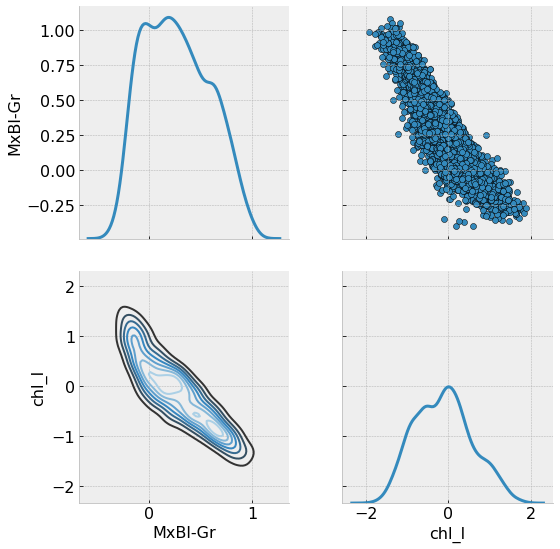

In [11]:
g = PairGrid(d_[['MxBl-Gr', 'chl_l']].dropna(), size=4)
gmu = g.map_upper(pl.scatter, edgecolor='k')
gml = g.map_lower(kdeplot, cmap="Blues_d")
gmd = g.map_diag(kdeplot, lw=3, legend=False);
g.savefig('./figJar/datapairgrid.png', dpi=300)

/home/madhatter106/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/madhatter106/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/madhatter106/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


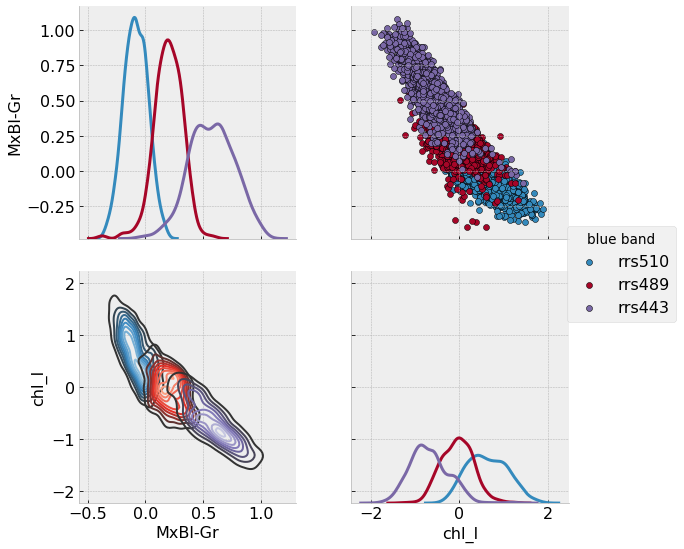

In [12]:
# Pairwise plot with blue band-clustering
vars_ = ['MxBl-Gr', 'chl_l']
cmaps_ = ["Blues_d", "Reds_d", "Purples_d"]
g = PairGrid(d_, vars=vars_, size=4, hue='mxBlId',  hue_kws={'cmap': cmaps_},
             dropna=True)
gmu = g.map_upper(pl.scatter, edgecolor='k')
gml = g.map_lower(kdeplot,)
gmd = g.map_diag(kdeplot, lw=3, legend=False);
g.add_legend(title='blue band')
g.savefig('./figJar/datapairgrid_blue.png', dpi=300)

In [13]:
d2.Province.value_counts()

Benguela Current Coastal Province    67
NW Arabian Upwelling Province        63
Atlantic Arctic Province             50
Kuroshio Current Province            35
Name: Province, dtype: int64

In [30]:
d2.head()

mxBlId                           Province  provCat  mxBlCat  \
8   rrs510  Benguela Current Coastal Province        5        2   
9   rrs510  Benguela Current Coastal Province        5        2   
10  rrs510  Benguela Current Coastal Province        5        2   
11  rrs510  Benguela Current Coastal Province        5        2   
12  rrs510  Benguela Current Coastal Province        5        2   

    log10(Blue-Green Ratio)  oisst  etopo2_l     chl  log10(chl)  
8                  0.009951  17.21  2.096910  2.6363    0.420995  
9                  0.009238  17.21  2.096910  2.5190    0.401228  
10                -0.120048  17.21  2.068186  5.6430    0.751510  
11                -0.089802  15.88  2.190332  4.6130    0.663983  
12                -0.050064  15.88  2.296665  2.8300    0.451786

In [15]:
d2.rename(columns={'chl_l': 'log10(chl)', 'MxBl-Gr': 'log10(Blue-Green Ratio)'}, inplace=True)

/home/madhatter106/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


/home/madhatter106/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/madhatter106/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/madhatter106/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/madhatter106/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


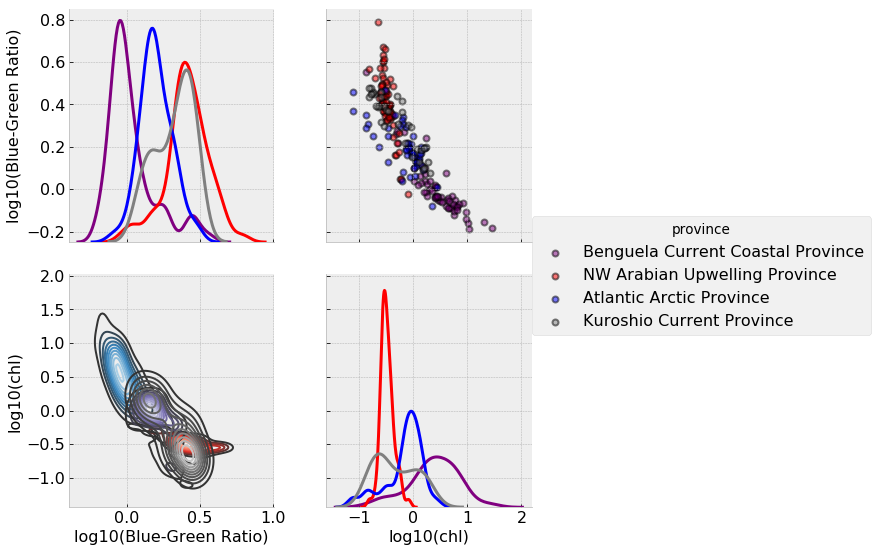

In [16]:
# Pairwise plot with biome band-clustering
vars_ = ['log10(Blue-Green Ratio)', 'log10(chl)']
cmaps_ = ["Blues_d", "Reds_d", "Purples_d", "Greys_d"]
g = PairGrid(d2, vars=vars_, size=4, hue='Province',
             palette={'Atlantic Arctic Province': 'blue',
                      'NW Arabian Upwelling Province': 'red',
                      'Benguela Current Coastal Province': 'purple',
                      'Kuroshio Current Province': 'grey'},
             hue_kws={'cmap': cmaps_}, dropna=True)
gmu = g.map_upper(pl.scatter, edgecolor='k', alpha=0.5, linewidth=2)
gml = g.map_lower(kdeplot,)
gmd = g.map_diag(kdeplot, lw=3, legend=False);
g.add_legend(title='province')
g.savefig('./figJar/datapairgrid_province.png', dpi=300)

In [28]:
len(g.palette)

12

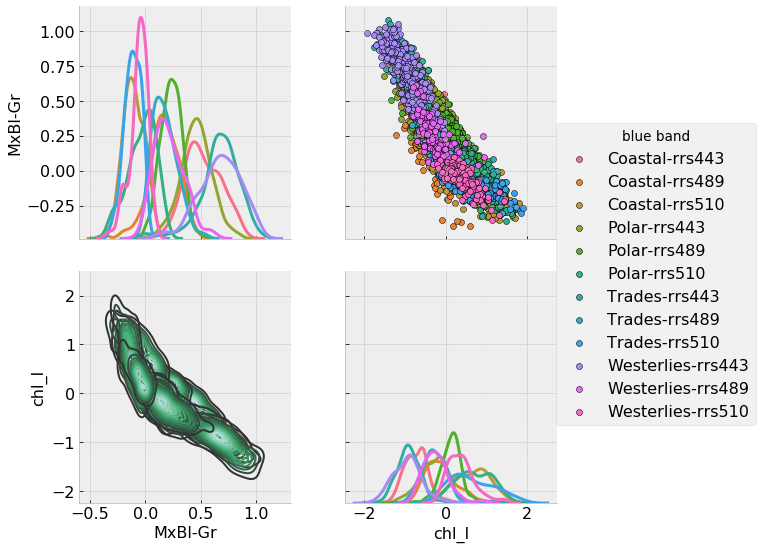

In [26]:
# Pairwise plot with blue band-clustering
vars_ = ['MxBl-Gr', 'chl_l']
#cmaps_ = ["Blues_d", "Reds_d", "Purples_d"]
g = PairGrid(d_, vars=vars_, size=4, hue='blueBiome',  #hue_kws={'cmap': cmaps_},
             dropna=True)
g.
gmu = g.map_upper(pl.scatter, edgecolor='k')
gml = g.map_lower(kdeplot,)
gmd = g.map_diag(kdeplot, lw=3, legend=False);
g.add_legend(title='blue band')
#g.savefig('./figJar/datapairgrid_blue.png', dpi=300)

In [7]:
n_provinces = d_.provCat.unique().size
n_blues = d_.mxBlCat.unique().size
n_biomes = d_.biomCat.unique().size
provIdx = d_.provCat.values
blueIdx = d_.mxBlCat.values
biomeIdx = d_.biomCat.values
log_band_ratio = d_['MxBl-Gr'].values
log_depth = d_['etopo2_l'].values
sst = d_['oisst'].values
predicted = d_['chl_l'].values

#### <u>Baseline Model - The OC4 Clone</u>

In [41]:
with pm.Model() as m0:
    alpha = pm.Normal('a', 0, 10)
    beta = pm.Normal('b', 0, 10, shape=4)
    sigma_model = pm.HalfCauchy('sigma_model', beta=5)
    mu_ = alpha + beta[0] * log_band_ratio + beta[1] * log_band_ratio ** 2 +\
        beta[2] * log_band_ratio**3 + beta[3] * log_band_ratio**4
    log_chl = pm.Normal('log_chl', mu=mu_, sd=sigma_model, observed=predicted)
    trace_0 = pm.sample(5000, tune=5000, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_model_log__, b, a]
  5%|▍         | 455/10000 [00:09<03:28, 45.69it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [03:38<00:00, 45.67it/s]


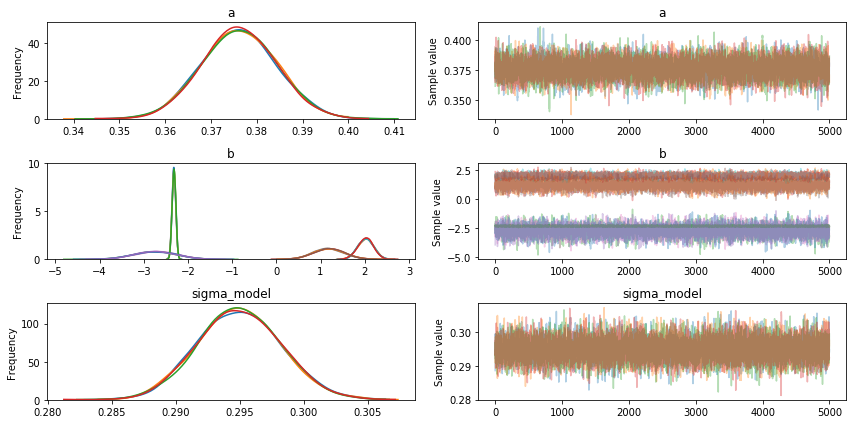

In [42]:
pm.traceplot(trace_0);

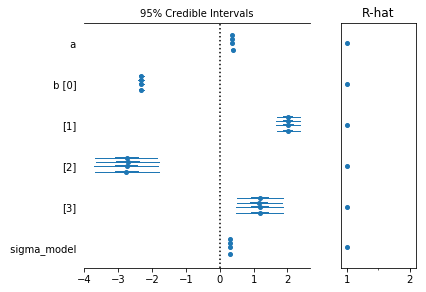

In [43]:
pm.forestplot(trace_0);

### <u> Hierarchical Models</u>
#### <u>The Max(Blue)-Clustered Model</u>

In [8]:
with pm.Model() as mdl_bl:
    # hyperpriors
    mu_a = pm.Normal('mu_a', 0, sd=100)
    sigma_a = pm.HalfCauchy('sigma_a', 2.5)
    mu_b = pm.Normal('mu_b', 0, sd=100)
    sigma_b = pm.HalfCauchy('sigma_b', 2.5)
    #priors
    
    a_blue = pm.Normal('a_blue', mu=mu_a, sd=sigma_a, shape=n_blues)
    b_blue = pm.Normal('b_blue', mu=mu_b, sd=sigma_b, shape=n_blues)
    
    #forward model & model error
    mu_ = a_blue[blueIdx] + b_blue[blueIdx] * log_band_ratio
    eps = pm.HalfCauchy('eps', beta=5)
    
    #likelihood
    log_chl = pm.Normal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_bl = pm.sample(5000, tune=5000, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b_blue, a_blue, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
 10%|▉         | 956/10000 [00:09<01:34, 95.79it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [01:07<00:00, 148.26it/s]
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.702834512364031, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


#### Model Diagnostics

In [9]:
pm.summary(trace_bl)

mean        sd  mc_error   hpd_2.5  hpd_97.5         n_eff  \
mu_a       0.355913  0.365036  0.007997 -0.243873  0.958039   2125.193049   
mu_b      -2.133977  1.183655  0.020802 -4.398306  0.224003   3447.214619   
a_blue__0  0.439375  0.021834  0.000241  0.397735  0.482939  10618.286545   
a_blue__1  0.236244  0.015510  0.000165  0.205532  0.265892   9831.388563   
a_blue__2  0.381081  0.010744  0.000088  0.360092  0.402039  13743.027786   
b_blue__0 -1.941695  0.036065  0.000385 -2.014456 -1.873735  10911.682760   
b_blue__1 -1.422457  0.066267  0.000743 -1.551803 -1.294331   9549.825225   
b_blue__2 -3.052507  0.081642  0.000711 -3.212966 -2.893088  13952.912394   
sigma_a    0.361902  0.516460  0.009590  0.036200  1.177666   2662.094239   
sigma_b    1.573177  1.396018  0.018811  0.324146  3.768398   4438.142382   
eps        0.288952  0.003183  0.000024  0.282836  0.295426  17719.922906   

               Rhat  
mu_a       1.001048  
mu_b       1.000149  
a_blue__0  0.999989  
a_blue__1  0.999902  
a_blue__2  1.000112  
b_blue__0  0.999961  
b_blue__1  1.000005  
b_blue__2  1.000149  
sigma_a    1.000673  
sigma_b    1.000891  
eps        0.999928

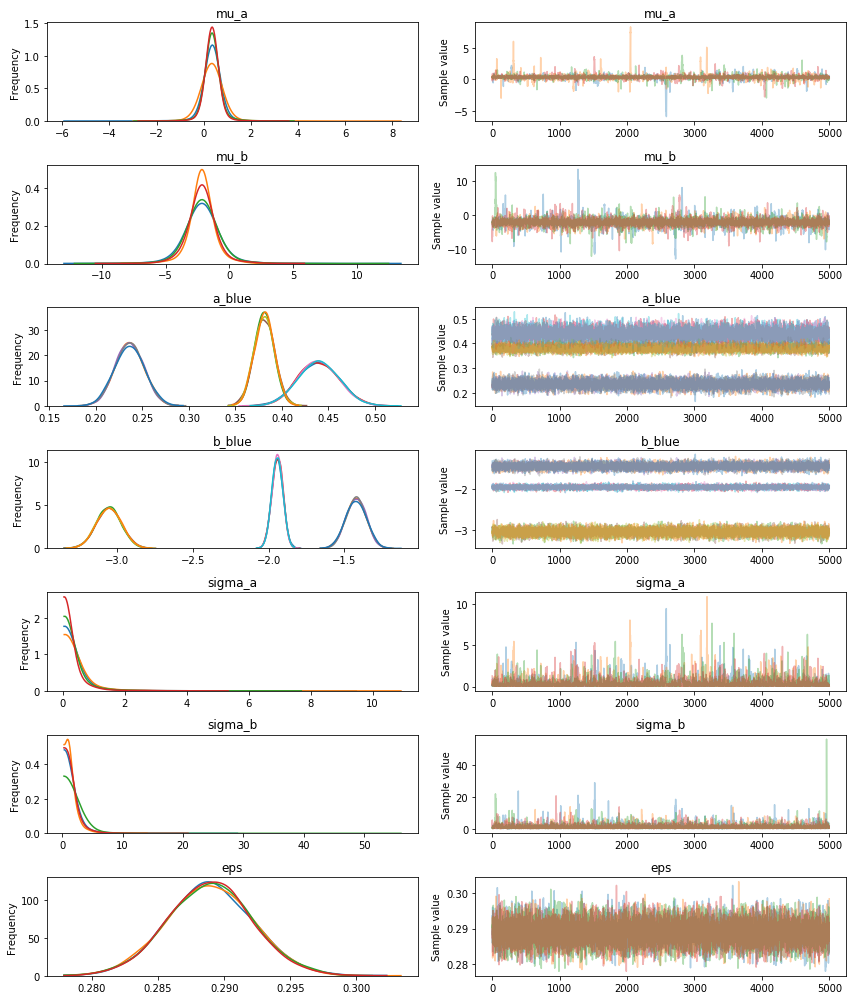

In [10]:
pm.traceplot(trace_bl);

#### Posterior Predictive Checks

In [152]:
# ppc on max-blue-band clustering
ppc_log_chl_bl = pm.sample_ppc(trace_bl, samples=1000, model=mdl_bl)['log_chl']

d_['pred_chl_l_bl_mean'] = ppc_log_chl_bl.mean(axis=0)

hpd_ppc_log_chl_bl = pm.hpd(ppc_log_chl_bl)
d_['pred_chl_l_bl_95lo'] = hpd_ppc_log_chl_bl[:, 0]
d_['pred_chl_l_bl_95hi'] = hpd_ppc_log_chl_bl[:, 1]
# Plot 

100%|██████████| 1000/1000 [00:00<00:00, 2019.41it/s]


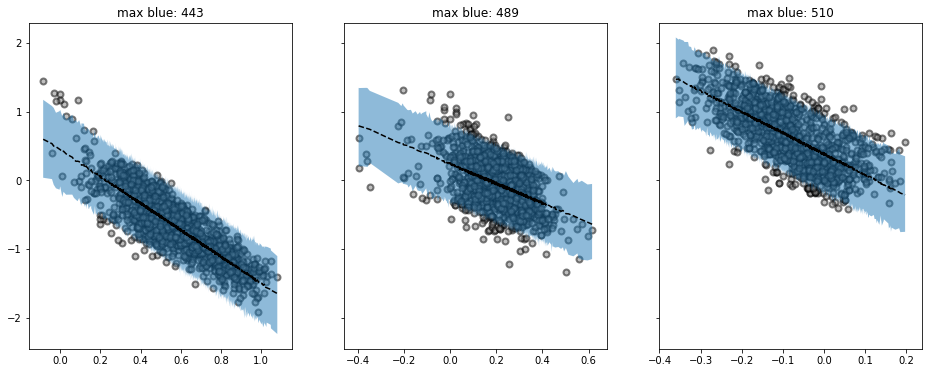

In [21]:
_, ax = pl.subplots(ncols=n_blues, figsize=(16, 6), sharey=True)
bands = ['443', '489' ,'510']
for i in range(n_blues):
    xy = d_.loc[d_.mxBlCat==i, ['MxBl-Gr', 'pred_chl_l_bl_mean', 'pred_chl_l_bl_95lo', 
                                'pred_chl_l_bl_95hi', 'chl_l']].values
    ix = np.argsort(xy[:, 0])
    ax[i].scatter(xy[:, 0], xy[:, -1], facecolor='gray', edgecolor='k',
                 alpha=0.5, linewidth=2)
    ax[i].set_title(f'max blue: {bands[i]}')
    ax[i].plot(xy[ix, 0], xy[ix, 1], 'k--')
    ax[i].fill_between(xy[ix, 0], xy[ix, 2], xy[ix, 3], alpha=0.5)

#### <u>Biome-clustered model</u>

In [22]:
with pm.Model() as mdl_biom:
    # hyperpriors
    mu_a = pm.Normal('mu_a', 0, sd=100)
    sigma_a = pm.HalfCauchy('sigma_a', 2.5)
    mu_b = pm.Normal('mu_b', 0, sd=100)
    sigma_b = pm.HalfCauchy('sigma_b', 2.5)
    #priors
    
    a_biome = pm.Normal('a_biome', mu=mu_a, sd=sigma_a, shape=n_biomes)
    b_biome = pm.Normal('b_biome', mu=mu_b, sd=sigma_b, shape=n_biomes)
    
    #forward model & model error
    mu_ = a_biome[biomeIdx] + b_biome[biomeIdx] * log_band_ratio
    eps = pm.HalfCauchy('eps', beta=5)
    
    #likelihood
    log_chl = pm.Normal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_biom = pm.sample(5000, tune=5000, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b_biome, a_biome, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
 13%|█▎        | 1326/10000 [00:09<01:04, 133.52it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [00:43<00:00, 228.88it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8114898772280278, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.832747905234835, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters

#### Model Diagnostics

In [23]:
pm.summary(trace_biom)

mean        sd  mc_error   hpd_2.5  hpd_97.5         n_eff  \
mu_a        0.394693  0.224920  0.004052  0.008586  0.804655   3159.599172   
mu_b       -1.977085  0.260478  0.005403 -2.474731 -1.509529   2548.928569   
a_biome__0  0.368627  0.007912  0.000058  0.352979  0.383782  20543.695892   
a_biome__1  0.616437  0.011898  0.000099  0.593164  0.639957  13668.124438   
a_biome__2  0.361564  0.016019  0.000128  0.329689  0.392176  13634.926908   
a_biome__3  0.227254  0.015779  0.000123  0.196480  0.258153  14996.455130   
b_biome__0 -2.214039  0.027206  0.000187 -2.266720 -2.159911  19709.172395   
b_biome__1 -2.038993  0.033837  0.000277 -2.106040 -1.974069  13977.473847   
b_biome__2 -1.885840  0.027693  0.000206 -1.938540 -1.830417  14831.659781   
b_biome__3 -1.754105  0.029258  0.000240 -1.812130 -1.697052  14813.960854   
sigma_a     0.320016  0.287889  0.004590  0.074676  0.807388   4087.775024   
sigma_b     0.386154  0.352318  0.006405  0.087117  0.934683   3430.030970   
eps         0.272791  0.003024  0.000021  0.266758  0.278567  20128.289852   

                Rhat  
mu_a        1.000650  
mu_b        1.001077  
a_biome__0  1.000042  
a_biome__1  0.999978  
a_biome__2  0.999990  
a_biome__3  1.000120  
b_biome__0  0.999980  
b_biome__1  0.999989  
b_biome__2  0.999946  
b_biome__3  1.000116  
sigma_a     1.000101  
sigma_b     0.999972  
eps         0.999929

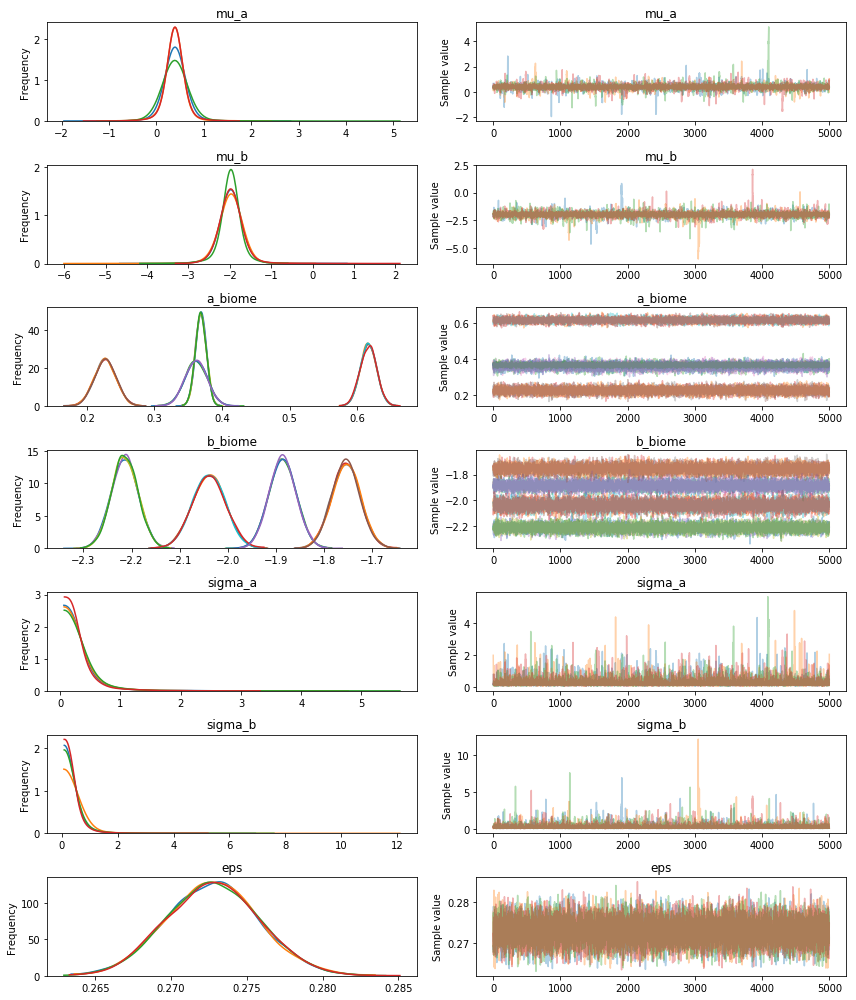

In [24]:
pm.traceplot(trace_biom);

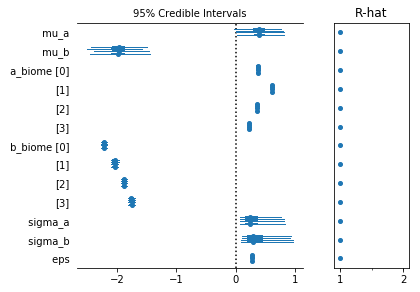

In [25]:
pm.forestplot(trace_biom);

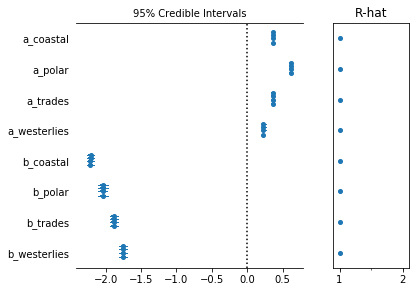

In [27]:
pm.forestplot(trace_biom, varnames=['a_biome', 'b_biome'], 
              ylabels=['a_coastal', 'a_polar', 'a_trades', 'a_westerlies',
                      'b_coastal', 'b_polar', 'b_trades', 'b_westerlies']);

#### Posterior Predictive Checks

In [28]:
# ppc on max-blue-band clustering
ppc_log_chl_biom = pm.sample_ppc(trace_biom, samples=1000, model=mdl_biom)['log_chl']

d_['pred_chl_l_biom_mean'] = ppc_log_chl_biom.mean(axis=0)

hpd_ppc_log_chl_biom = pm.hpd(ppc_log_chl_biom)
d_['pred_chl_l_biom_95lo'] = hpd_ppc_log_chl_biom[:, 0]
d_['pred_chl_l_biom_95hi'] = hpd_ppc_log_chl_biom[:, 1]
del ppc_log_chl_biom, hpd_ppc_log_chl_biom

100%|██████████| 1000/1000 [00:00<00:00, 1840.16it/s]


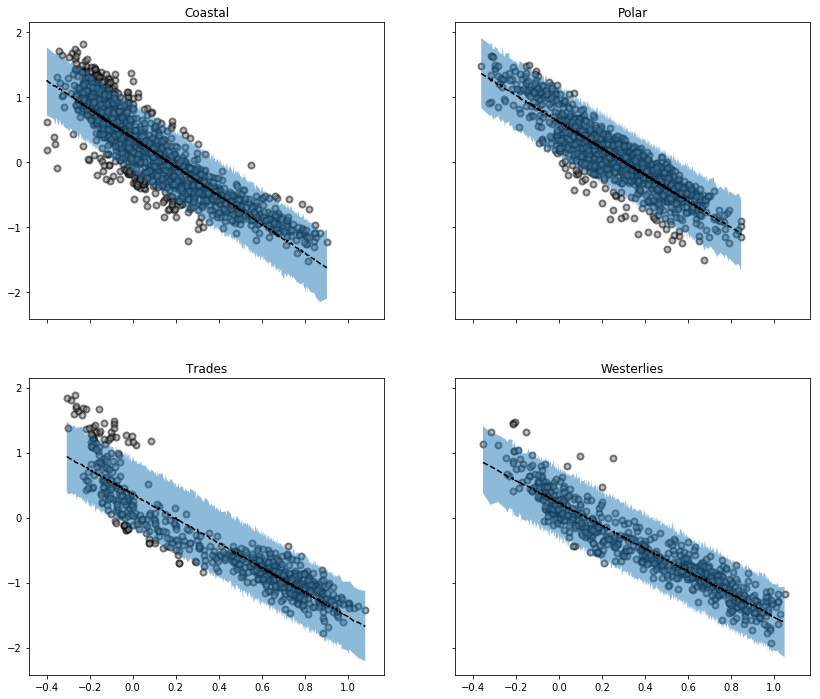

In [32]:
_, axs = pl.subplots(ncols=2, nrows=2, figsize=(14, 12), sharey=True, sharex=True)
ax = axs.ravel()
for i in range(n_biomes):
    xy = d_.loc[d_.biomCat==i, ['MxBl-Gr', 'pred_chl_l_biom_mean', 'pred_chl_l_biom_95lo', 
                                'pred_chl_l_biom_95hi', 'chl_l']].values
    ix = np.argsort(xy[:, 0])
    ax[i].scatter(xy[:, 0], xy[:, -1], facecolor='gray', edgecolor='k',
                 alpha=0.5, linewidth=2)
    ax[i].set_title(f'{biome_mapping[i]}')
    ax[i].plot(xy[ix, 0], xy[ix, 1], 'k--')
    ax[i].fill_between(xy[ix, 0], xy[ix, 2], xy[ix, 3], alpha=0.5)

#### <u>Province-clustered model</u>

In [33]:
with pm.Model() as mdl_prov:
    # hyperpriors
    mu_a = pm.Normal('mu_a', 0, sd=100)
    sigma_a = pm.HalfCauchy('sigma_a', 2.5)
    mu_b = pm.Normal('mu_b', 0, sd=100)
    sigma_b = pm.HalfCauchy('sigma_b', 2.5)
    #priors
    
    a_prov = pm.Normal('a_prov', mu=mu_a, sd=sigma_a, shape=n_provinces)
    b_prov = pm.Normal('b_prov', mu=mu_b, sd=sigma_b, shape=n_provinces)
    
    #forward model & model error
    mu_ = a_prov[provIdx] + b_prov[provIdx] * log_band_ratio
    eps = pm.HalfCauchy('eps', beta=5)
    
    #likelihood
    log_chl = pm.Normal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_prov = pm.sample(5000, tune=5000, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, b_prov, a_prov, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
  5%|▍         | 485/10000 [00:09<03:14, 48.94it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [02:25<00:00, 68.54it/s]


#### Model Diagnostics

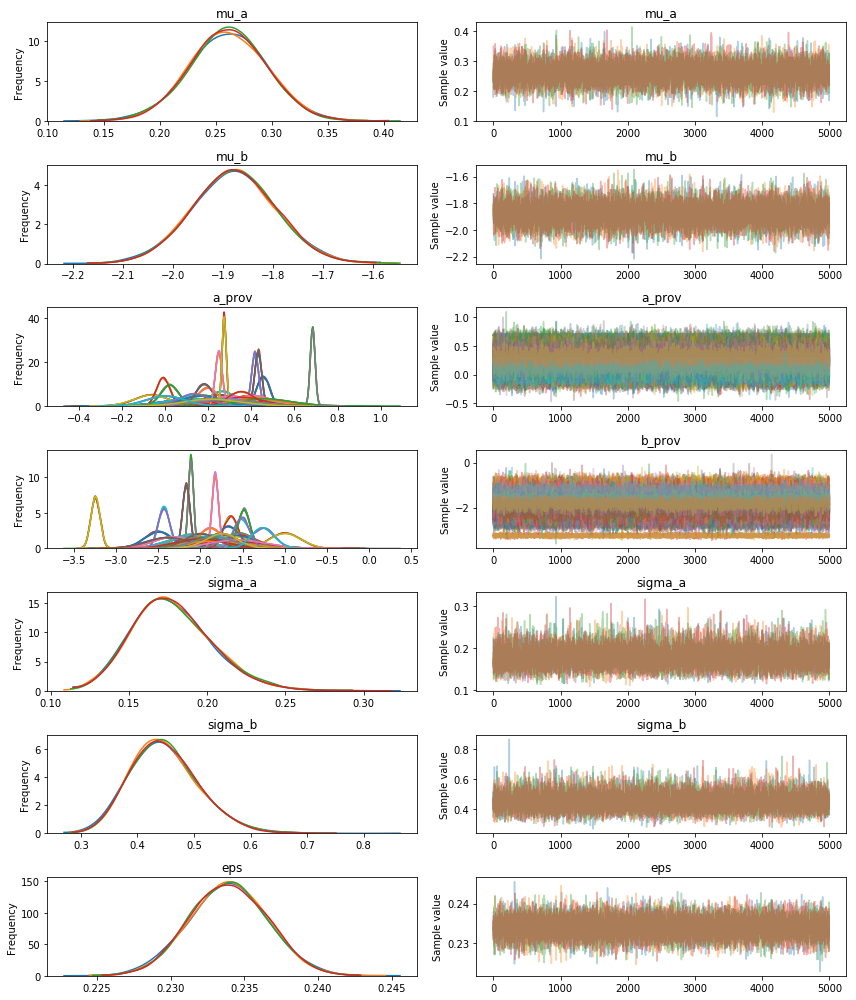

In [34]:
pm.traceplot(trace_prov);

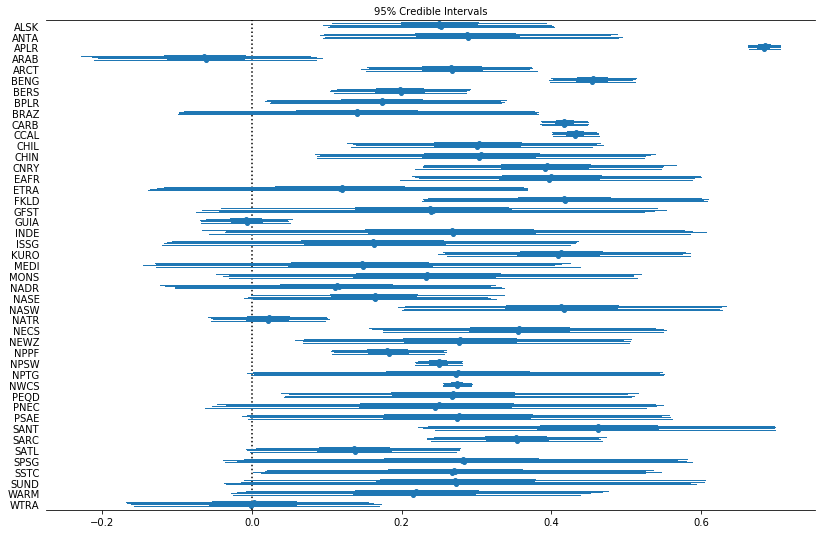

In [36]:
gs = pm.forestplot(trace_prov, varnames=['a_prov'], rhat=False,
                   ylabels=[prov_mapping[i] for i in range(n_provinces)])
f = pl.gcf()
f.set_figheight(8)
f.set_figwidth(12)

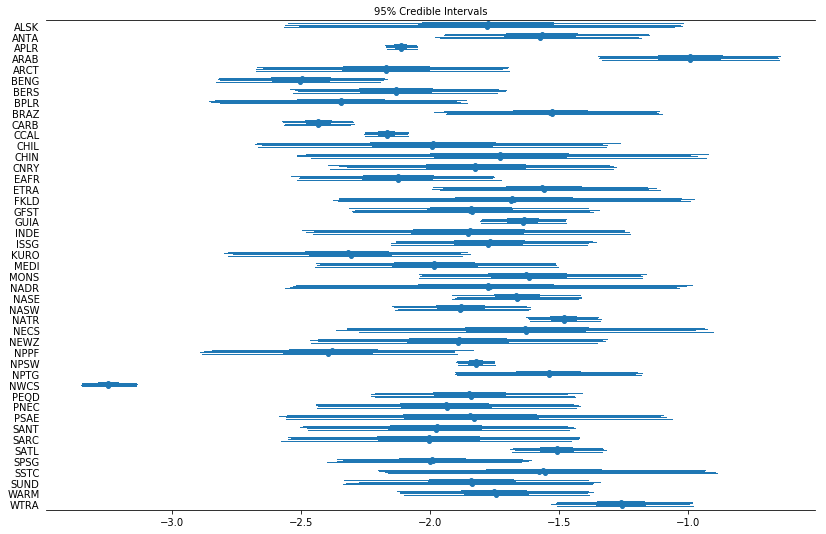

In [35]:
gs = pm.forestplot(trace_prov, varnames=['b_prov'], rhat=False,
                   ylabels=[prov_mapping[i] for i in range(n_provinces)])
f = pl.gcf()
f.set_figheight(8)
f.set_figwidth(12)

#### Posterior Predictive Checks

In [71]:
# ppc on max-blue-band clustering
ppc_log_chl_prov = pm.sample_ppc(trace_prov, samples=1000, model=mdl_prov)['log_chl']
d_['pred_chl_l_prov_mean'] = ppc_log_chl_prov.mean(axis=0)
hpd_ppc_log_chl_prov = pm.hpd(ppc_log_chl_prov)
d_['pred_chl_l_prov_95lo'] = hpd_ppc_log_chl_prov[:, 0]
d_['pred_chl_l_prov_95hi'] = hpd_ppc_log_chl_prov[:, 1]
del ppc_log_chl_prov, hpd_ppc_log_chl_prov

100%|██████████| 1000/1000 [00:00<00:00, 1829.13it/s]


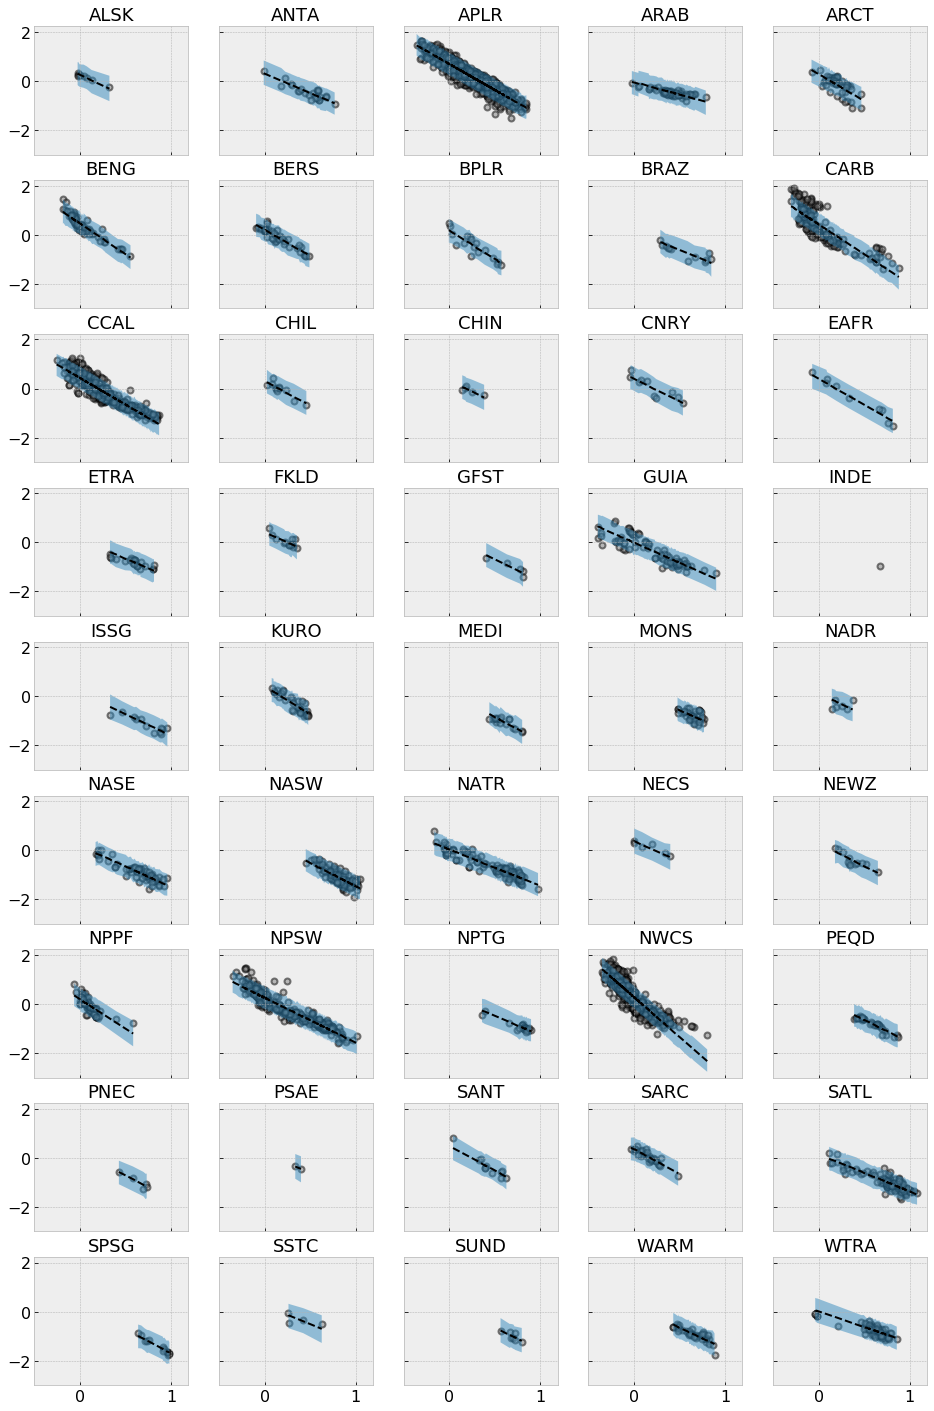

In [147]:
_, axs = pl.subplots(nrows=9, ncols=5, figsize=(16, 25), sharex=True, sharey=True)
ax = axs.ravel()
for i, prov in prov_mapping.items():
    xy = d_.loc[d_.provCat==i, ['MxBl-Gr', 'pred_chl_l_prov_mean', 'pred_chl_l_prov_95lo', 
                                'pred_chl_l_prov_95hi', 'chl_l']].values

    ix = np.argsort(xy[:, 0])
    ax[i].scatter(xy[:, 0], xy[:, -1], facecolor='gray', edgecolor='k',
                  alpha=0.5, linewidth=2, label=leg[0])
    ax[i].set_title(f'{prov}')
    ax[i].plot(xy[ix, 0], xy[ix, 1], 'k--', label=leg[1])
    ax[i].fill_between(xy[ix, 0], xy[ix, 2], xy[ix, 3], alpha=0.5, )

### <u> Hierarchical Models with Covarying Slopes and Intercepts</u>

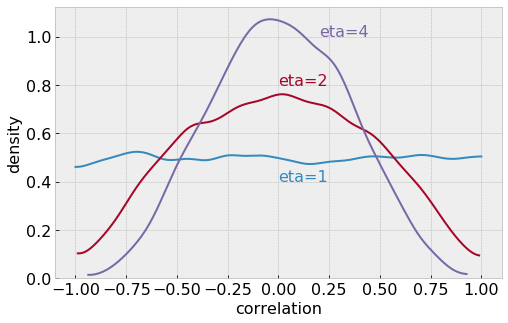

In [150]:
f, ax = pl.subplots(figsize=(8, 5))
textlocs = [[0, 0.4,], [0, 0.8], [0.2, 1]]
for i, (loc, eta) in enumerate(zip(textlocs, [1, 2, 4])):
    r = pm.LKJCorr.dist(n=2, eta=eta).random(size=10000)
    pm.kdeplot(r, ax=ax)
    ax.text(loc[0], loc[1], f'eta={eta}', color=ax.lines[i].get_color())
ax.set_xlabel('correlation')
ax.set_ylabel('density');
f.savefig('./figJar/Hierarchical models/lkjcholprior.png', dpi=300, format='png')

#### <u>Biogeochemical Province-Clustered Model with Covarying Slopes and Intercepts</u>

In [62]:
with pm.Model() as mdl_prov_cov_nc:
    # hyperpriors
    # -----------
    a_prov_hyp = pm.Normal('a_prov_hyp', 0, 10) # intercept hyperprior
    b_prov_hyp = pm.Normal('b_prov_hyp', 0, 1) # slope hyperprior
    sd_dist = pm.HalfCauchy.dist(beta=2)
    # cov hyperprior
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=4, n=2, sd_dist=sd_dist)
    
    # priors
    # ----------
    # convert triangular cholesky factor matrix to 2D array
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    # compute prior on intercept and slope
    ab_prov = pm.MvNormal('ab_prov', mu=np.zeros(2), chol=chol, shape=(n_provinces, 2))
    
    # extract intercepts
    a_prov = pm.Deterministic('a_prov', ab_prov[:, 0] + a_prov_hyp)
    # extract slopes
    b_prov = pm.Deterministic('b_prov', ab_prov[:, 1] + b_prov_hyp)
    # extract correlation (rho)
    cov = tt.dot(chol, chol.T)
    sigma_ab = pm.Deterministic('sigma_ab', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    rho = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # forward model & model error
    mu_ = a_prov[provIdx] + b_prov[provIdx] * log_band_ratio
    eps = pm.HalfCauchy('eps', beta=2)
    #likelihood
    log_chl = pm.Normal('log_chl', mu=mu_, sd=eps, observed=predicted)
    trace_prov_cov_nc = pm.sample(5000, tune=5000, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, ab_prov, chol_cov_cholesky_cov_packed__, b_prov_hyp, a_prov_hyp]
  1%|          | 86/10000 [00:09<18:59,  8.70it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10000/10000 [05:53<00:00, 28.25it/s]
The number of effective samples is smaller than 25% for some parameters.


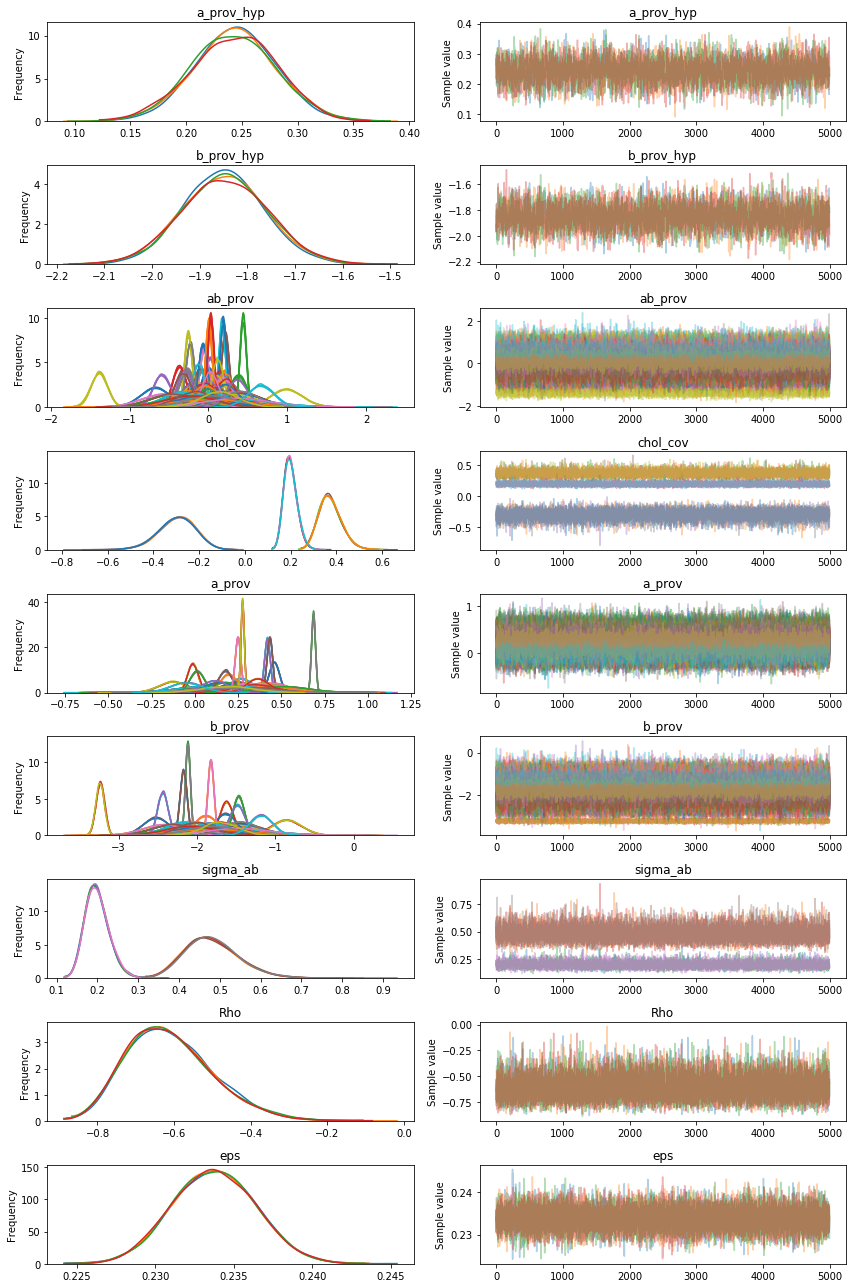

In [63]:
pm.traceplot(trace_prov_cov_nc);

In [76]:
d_.drop(['pred_chl_l_prov_cov_nc_95hi'], axis=1, inplace=True)

In [77]:
d_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4126 entries, 0 to 4458
Data columns (total 19 columns):
mxBlId                         4126 non-null object
provCat                        4126 non-null int8
mxBlCat                        4126 non-null int8
biomCat                        4126 non-null int8
MxBl-Gr                        4126 non-null float64
oisst                          4126 non-null float64
etopo2_l                       4126 non-null float64
chl                            4126 non-null float64
chl_l                          4126 non-null float64
pred_chl_l_bl_mean             4126 non-null float64
pred_chl_l_bl_95lo             4126 non-null float64
pred_chl_l_bl_95hi             4126 non-null float64
pred_chl_l_biom_mean           4126 non-null float64
pred_chl_l_biom_95lo           4126 non-null float64
pred_chl_l_biom_95hi           4126 non-null float64
pred_chl_l_prov_mean           4126 non-null float64
pred_chl_l_prov_95lo           4126 non-null float64
pr

In [78]:
ppc_log_chl_prov = pm.sample_ppc(trace_prov_cov_nc,
                                 samples=1000, model=mdl_prov_cov_nc)['log_chl']
d_['pred_chl_l_prov_cov_nc_mean'] = ppc_log_chl_prov.mean(axis=0)
hpd_ppc_log_chl_prov = pm.hpd(ppc_log_chl_prov)
d_['pred_chl_l_prov_cov_nc_95lo'] = hpd_ppc_log_chl_prov[:, 0]
d_['pred_chl_l_prov_cov_nc_95hi'] = hpd_ppc_log_chl_prov[:, 1]
del ppc_log_chl_prov, hpd_ppc_log_chl_prov

100%|██████████| 1000/1000 [00:00<00:00, 1832.35it/s]


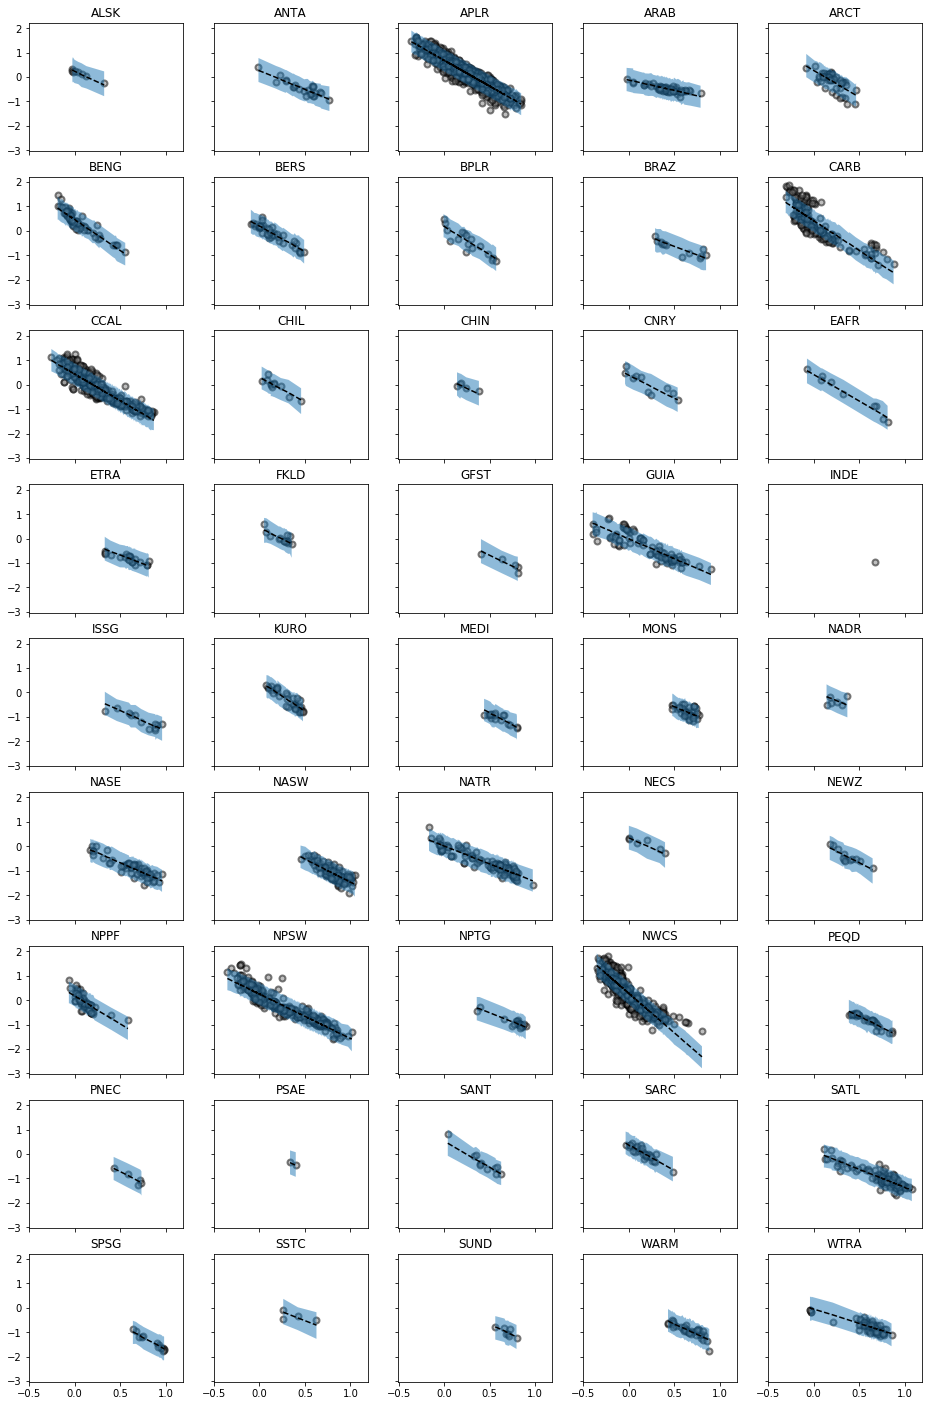

In [79]:
_, axs = pl.subplots(nrows=9, ncols=5, figsize=(16, 25), sharex=True, sharey=True)
ax = axs.ravel()
for i, prov in prov_mapping.items():
    xy = d_.loc[d_.provCat==i, ['MxBl-Gr', 'pred_chl_l_prov_cov_nc_mean',
                                'pred_chl_l_prov_cov_nc_95lo', 
                                'pred_chl_l_prov_cov_nc_95hi', 'chl_l']].values
    ix = np.argsort(xy[:, 0])
    ax[i].scatter(xy[:, 0], xy[:, -1], facecolor='gray', edgecolor='k',
                  alpha=0.5, linewidth=2)
    ax[i].set_title(f'{prov}')
    ax[i].plot(xy[ix, 0], xy[ix, 1], 'k--')
    ax[i].fill_between(xy[ix, 0], xy[ix, 2], xy[ix, 3], alpha=0.5)

### <u> Model Comparison</u>

#### Comparing Posterior Predictive Density Distributions to Data

Here I perform a qualitative comparison between the kernel density estimate and many samples drawn from the posterior predictive distribution of each model to see which model is able to simulate new data that are more similar to the observations on hand. This is a qualitative plot that helps provide a more complete picture of how well the model is doing.

In [179]:
ppc_dict = {}
ppc_dict['pooled'] = pm.sample_ppc(trace_0, samples=1000, model=m0)['log_chl']
ppc_dict['blue-clustered'] = pm.sample_ppc(trace_bl, samples=1000, model=mdl_bl)['log_chl']
ppc_dict['biome-clustered'] = pm.sample_ppc(trace_biom, samples=1000,
                                         model=mdl_biom)['log_chl']
ppc_dict['province-clustered'] = pm.sample_ppc(trace_prov, samples=1000,
                                       model=mdl_prov)['log_chl']
ppc_dict['prov.-clust.-w/cov'] = pm.sample_ppc(trace_prov_cov_nc, samples=1000,
                               model=mdl_prov_cov_nc)['log_chl']

100%|██████████| 1000/1000 [00:00<00:00, 1830.58it/s]


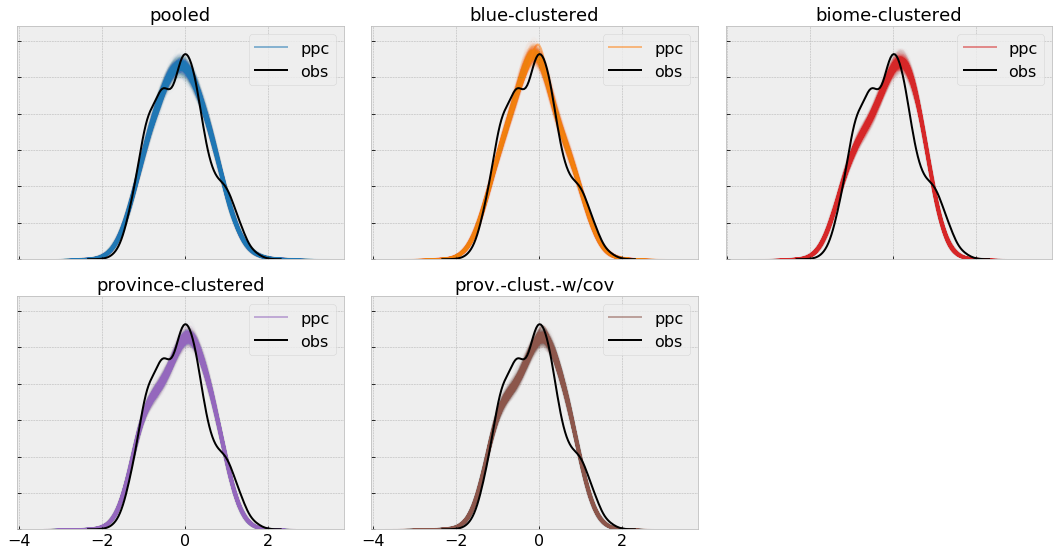

In [186]:
f, axs = pl.subplots(ncols=3, nrows=2, figsize=(15, 8), sharex=True, sharey=True)
ax = axs.ravel()
cm_ = cm.get_cmap('tab10')
cmh = [rgb2hex(cm_(i)[:3]) for i in [0, 1, 3, 4, 5]]
for axi, (key, val), col_hex in zip(ax[:-1], ppc_dict.items(), cmh):
    axi.set_yticklabels([])
    axi.set_title(key)
    for i in range(val.shape[0]):
        if i == 0:
            kdeplot(val[i], color=col_hex, alpha=0.5, ax=axi, label='ppc')
        else:
            kdeplot(val[i], color=col_hex, alpha=0.01, ax=axi)

    kdeplot(predicted, ax=axi, linewidth=2, color='k', label='obs')
ax[-1].set_visible(False)
f.tight_layout()
f.savefig('./figJar/kdeDensComp.png', dpi=300, format='png')

#### Skewness
Another possible check is comparison of skewness between the data and multiple draws from the posterior predictive distribution

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


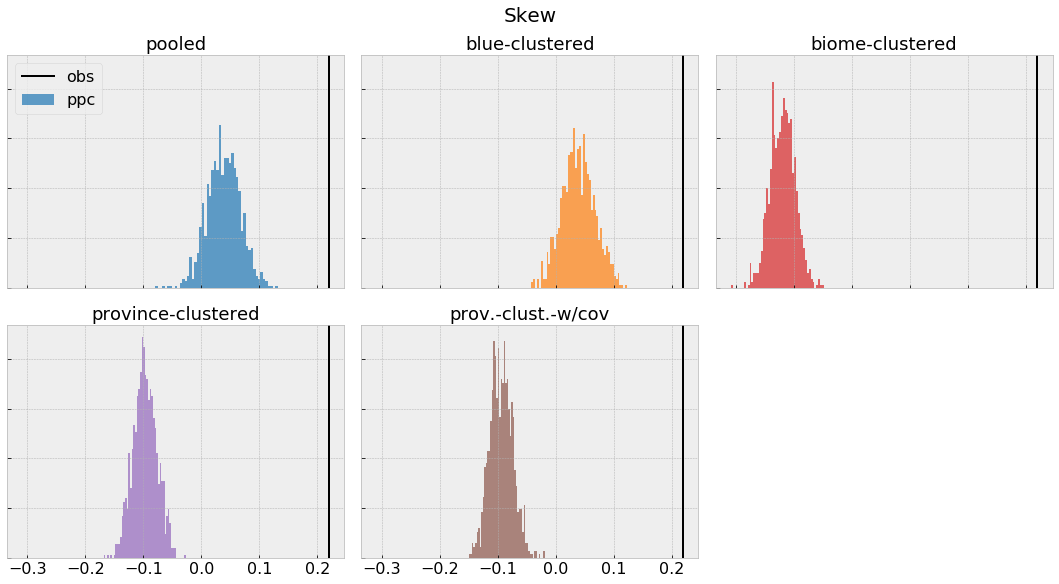

In [207]:
f, axs = pl.subplots(ncols=3, nrows=2, figsize=(15, 8), sharex=True, sharey=True)
ax = axs.ravel()
data_skew = skew(predicted)
for axi, (key, val), col_hex in zip(ax[:-1], ppc_dict.items(), cmh):
    axi.set_yticklabels([])
    axi.set_title(key)
    skewness = skew(val, axis=1)
    distplot(skewness, bins=50, ax=axi, kde=False, color=col_hex,
             hist_kws=dict(alpha=0.7, normed=True))
    axi.axvline(data_skew, linewidth=2, color='k')
ax[-1].set_visible(False)
ax[0].legend(['obs', 'ppc'])
f.suptitle('Skew', y=1.02)
f.tight_layout()
f.savefig('./figJar/skewnessComp.png', dpi=300, format='png')

Overall, the blue-clustered and pooled model show the closest skew to that of the data.

#### Within-group comparison
Here, I do pairwise pooled-other model comparison looking at the in-group performance for each model.
##### Pooled vs. blue-clustered model


#### Watanabe Akaike Information Criterion (WAIC) and Leave-One-Out Cross Validation (LOOCV)

In [87]:
# pickle models
traces = [trace_0, trace_bl, trace_biom, trace_prov, trace_prov_cov_nc]
m0.name = 'pooled'
mdl_bl.name = 'blue_clustered'
mdl_biom.name = 'biome_clustered'
mdl_prov.name = 'province_clustered'
mdl_prov_cov_nc.name = 'province_clustered_cov_effects'
mdls = [m0, mdl_bl, mdl_biom, mdl_prov, mdl_prov_cov_nc]
mdl_dict = {m.name: {'mdl': m, 'trc': t} for m, t in zip(mdls, traces)}

mdl_dict.update(dict(data=d_))

In [88]:
df_comp_waic = pm.compare({mdl: trace for mdl, trace in zip(mdls, traces)})
df_comp_waic

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC  pWAIC    dWAIC weight      SE  \
province_clustered_cov_effects  -236.63  47.27        0   0.93  117.42   
province_clustered              -229.71   47.4     6.93      0  117.49   
biome_clustered                  998.23  10.27  1234.87      0  113.35   
blue_clustered                  1470.22   8.06  1706.85   0.07   88.74   
pooled                           1641.3   8.76  1877.94      0  103.55   

                                   dSE var_warn  
province_clustered_cov_effects       0        1  
province_clustered                2.61        1  
biome_clustered                  79.58        0  
blue_clustered                   92.89        0  
pooled                          103.52        1

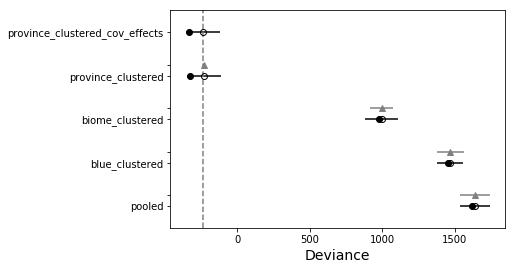

In [89]:
pm.compareplot(df_comp_waic);

In [90]:
df_comp_loo = pm.compare({mdl: trace for mdl, trace in zip(mdls, traces)}, ic='LOO')
df_comp_loo

LOO   pLOO     dLOO weight      SE  \
province_clustered_cov_effects  -235.61  47.78        0   0.93  117.43   
province_clustered              -228.63  47.93     6.98      0   117.5   
biome_clustered                  998.23  10.27  1233.84      0  113.35   
blue_clustered                  1470.22   8.06  1705.83   0.07   88.74   
pooled                          1641.34   8.78  1876.95      0  103.56   

                                   dSE shape_warn  
province_clustered_cov_effects       0          0  
province_clustered                2.64          0  
biome_clustered                  79.58          0  
blue_clustered                    92.9          0  
pooled                          103.54          0

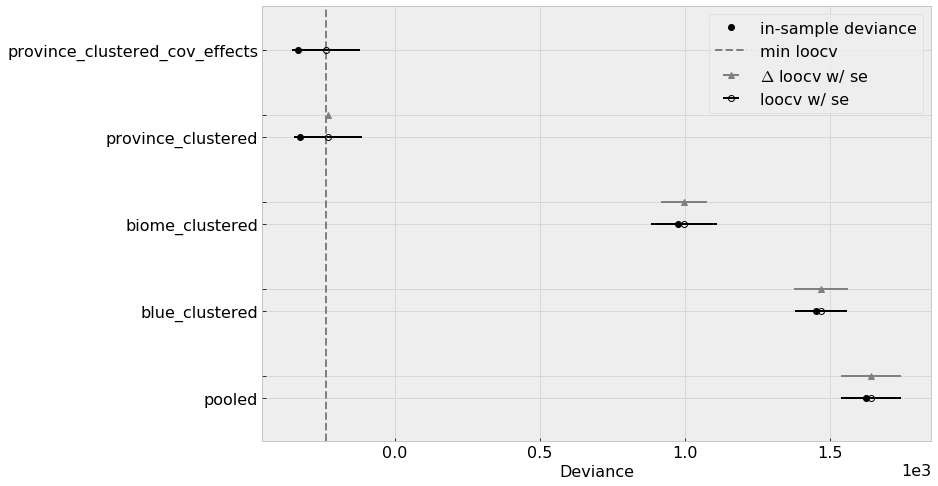

In [116]:
_, ax = pl.subplots(figsize=(12, 8))
ax = pm.compareplot(df_comp_loo, insample_dev=True, se=True, dse=True,
                    plot_kwargs=dict(fontsize=16), ax=ax)
ax.legend(['in-sample deviance', 'min loocv', r'$\Delta$ loocv w/ se', 'loocv w/ se'])

In [151]:
with open('./pickleJar/GaussianModels_single_cluster.pkl', 'wb') as f:
    pickle.dump(mdl_dict, f, protocol=pickle.HIGHEST_PROTOCOL)